In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [111]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
import xgboost as xgb
import pickle
import numpy as np
import seaborn as sns

# README
Welcome stranger to converting an RandomSearchCV model to XGBoost classifier model, adding the nessecary CAPICE code and plotting the ROC_AUC curves (including some other fancy plots).

Steps:

1. Run "convert_randomsearchcv_to_XGBClassifier" with argument 1 being the location of the randomized search cv model (full path including the file itself) and argument 2, the location of where the model file should be including the file name.

1. Copy "capice_v1_0_0.py" in `src/main/python/resources/models` and paste it in the same folder naming it something else (note: do not start the name with double underscore or Template!

1. Rename the class to something recognizeable and rename the "name" in the super() call of the init.

1. Copy the just renamed name of the super() variable to the config.cfg and paste it at [OVERWRITES]: modelfile = 

1. Run capice with the command `python3 capice.py -i /path/to/validation/dataset -o /path/to/recognizeable/output/folder

1. Run all above and including code cells where `plot_roc_curves` is defined.

1. Provide the full path to the datasets at each of the `pd.read_csv()` functions with their respective datasets. __Labels are hardcoded__.

1. Run the cell where datasets are loaded in.

1. Run the cell that calls the `plot_roc_curves`


In [3]:
def convert_randomsearchcv_to_XGBClassifier(randomsearchcv_loc, output_loc):
    with open(randomsearchcv_loc, 'rb') as model_file:
        model = pickle.load(model_file)
    xgboost_model = model.best_estimator_
    with open(output_loc, 'wb') as new_model_file:
        pickle.dump(xgboost_model, new_model_file)

In [54]:
location_of_validate_csv = '/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/validate.csv.gz'
validate = pd.read_csv(location_of_validate_csv)
merge_col = 'merge_col'
validate['b_label'] = 0
validate.loc[validate[validate['clinsig'] == 'LP'].index, 'b_label'] = 1
validate[merge_col] = validate[['chr', 'pos', 'ref', 'alt', 'gene']].astype(str).agg('_'.join, axis=1)
validate.drop(columns=['chr', 'pos', 'ref', 'alt', 'gene'], inplace=True)

/home/rjsietsma/PycharmProjects/capice_updatr/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [122]:
def merge_capice_output(capice_output, validation_dataset):
    data_cols_merge = ['chr', 'pos', 'ref', 'alt', 'gene_name']
    drop_cols = ['review', 'stars', 'source', merge_col]
    
    # Copying the dataset so changes will not be applied to the original dataset.
    output = capice_output.copy(deep=True)
    
    # Merging
    print('Merging')
    output[merge_col] = output[data_cols_merge].astype(str).agg('_'.join, axis=1)
    merged_output = output.merge(validation_dataset, on=[merge_col], how='left')
    merged_output.drop(columns=drop_cols, inplace=True)
    
    # Processing
    print('Processing')
    merged_output.drop_duplicates(inplace=True)
    merged_output.dropna(subset=['b_label'], inplace=True)
    merged_output['dif'] = abs(merged_output['score'] - merged_output['b_label'])
    merged_output.sort_values(by='dif', inplace=True)
    merged_output.drop_duplicates(subset=data_cols_merge, inplace=True)
    merged_output.sort_index(inplace=True)
    
    print('Done.')
    return merged_output

In [51]:
def plot_roc_curves(old_model, new_unbalanced_model, new_balanced_model):
    plt.rcParams['figure.figsize'] = (20,8)
    rounding = 4
    
    # Plotting
    fpr_old, tpr_old, _ = roc_curve(y_score = np.array(old_model['score']), y_true = np.array(old_model['b_label']))
    roc_auc_old = round(auc(fpr_old, tpr_old), rounding)
    plt.plot(fpr_old, tpr_old, color='black', label=f'Old (area={roc_auc_old})')
    
    # Plotting
    fpr_unbalanced, tpr_unbalanced, _ = roc_curve(y_score = np.array(new_unbalanced_model['score']), y_true = np.array(new_unbalanced_model['b_label']))
    roc_auc_unbalanced = round(auc(fpr_unbalanced, tpr_unbalanced), rounding)
    plt.plot(fpr_unbalanced, tpr_unbalanced, color='darkorange', label=f'Unbalanced (area={roc_auc_unbalanced})')
    
    # Plotting
    fpr_balanced, tpr_balanced, _ = roc_curve(y_score = np.array(new_balanced_model['score']), y_true = np.array(new_balanced_model['b_label']))
    roc_auc_balanced = round(auc(fpr_balanced, tpr_balanced), rounding)
    plt.plot(fpr_balanced, tpr_balanced, color='blue', label=f'Balanced (area={roc_auc_balanced})')
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('CAPICE Receiver operating characteristics')
    plt.legend()
    plt.show()

In [136]:
def plot_violin(old_model, new_unbalanced_model, new_balanced_model):
    fig, axes = plt.subplots(1, 3, figsize=(20,8), sharey=True)
    sns.violinplot(ax=axes[0], x='clinsig', y='score', data=merged_old_model)
    axes[0].set_title('Old')
    sns.violinplot(ax=axes[1], x='clinsig', y='score', data=merged_unbalanced_model)
    axes[1].set_title('Unbalanced')
    sns.violinplot(ax=axes[2], x='clinsig', y='score', data=merged_balanced_model)
    axes[2].set_title('Balanced')
    plt.show()

In [123]:
old_model = pd.read_csv('/home/rjsietsma/capice_projects/capice_vep_output_files/old/validate_vcf_vep_per_gene_capice.tsv.gz', sep='\t', low_memory=False)
old_model.drop(index=old_model[old_model['id_source'] != 'HGNC'].index, inplace=True)
merged_old_model = merge_capice_output(old_model, validate)

new_unbalanced_model = pd.read_csv('/home/rjsietsma/capice_projects/capice_vep_output_files/mk1/unbalanced/validate_vcf_vep_per_gene_capice.tsv.gz', sep='\t', low_memory=False)
new_unbalanced_model.drop(index=new_unbalanced_model[new_unbalanced_model['id_source'] != 'HGNC'].index, inplace=True)
merged_unbalanced_model = merge_capice_output(new_unbalanced_model, validate)

new_balanced_model = pd.read_csv('/home/rjsietsma/capice_projects/capice_vep_output_files/mk1/balanced/validate_vcf_vep_per_gene_capice.tsv.gz', sep='\t', low_memory=False)
new_balanced_model.drop(index=new_balanced_model[new_balanced_model['id_source'] != 'HGNC'].index, inplace=True)
merged_balanced_model = merge_capice_output(new_balanced_model, validate)

Merging
Processing
Done.
Merging
Processing
Done.
Merging
Processing
Done.


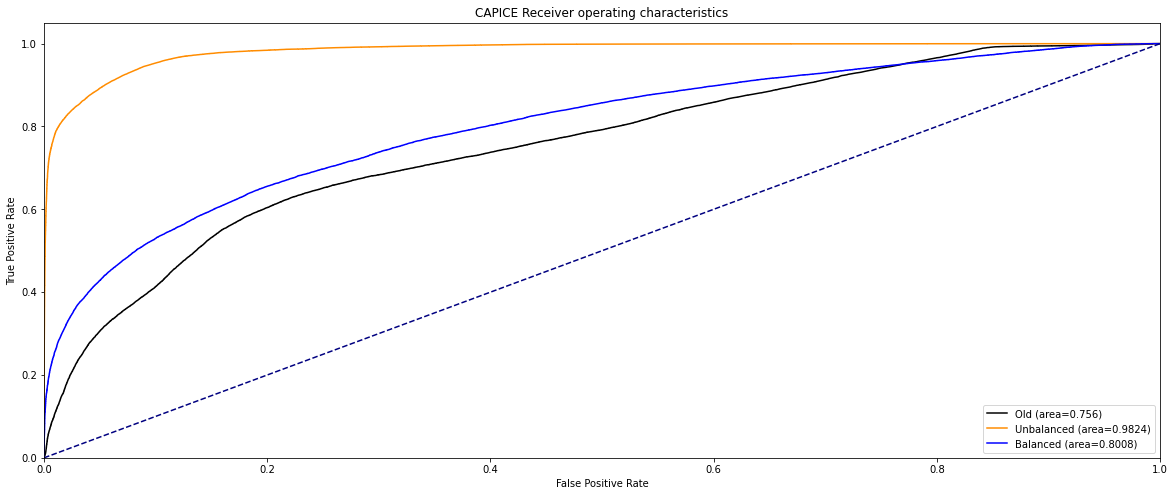

In [64]:
plot_roc_curves(merged_old_model, merged_unbalanced_model, merged_balanced_model)

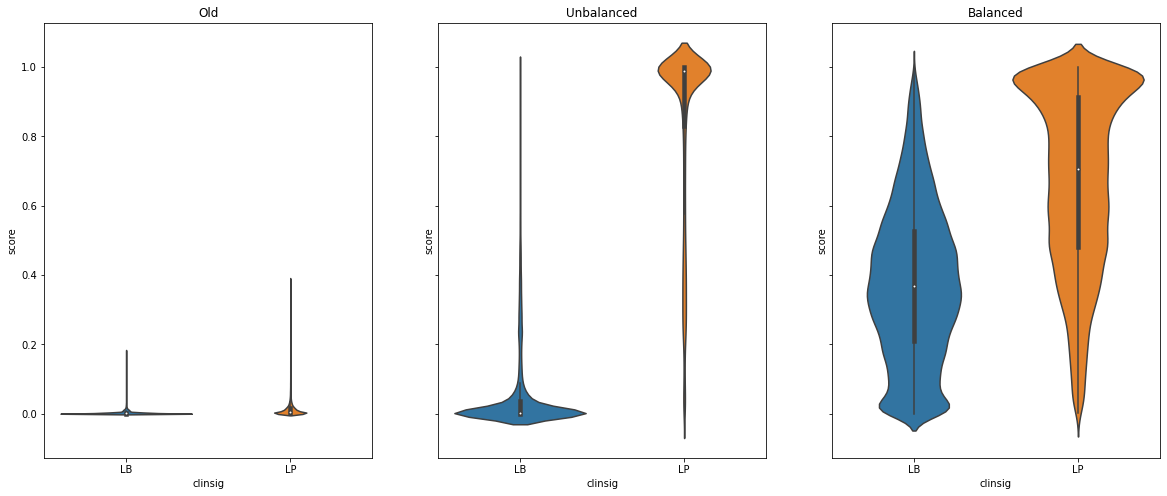

In [137]:
plot_violin(merged_old_model, merged_unbalanced_model, merged_balanced_model)

### Ideas for new plots:

- [X] Violin plots for the performance of benign vs pathogenic (reason: overfitting pathogenic / benign).
- [ ] Allele frequency plots like in [Li et al.](https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-020-00775-w#Fig3).
- [ ] Plots of the feature importances of the models themselfs..